In [8]:
import pandas as pd
import numpy as np

In [9]:
data = pd.read_csv('fer2013.csv')
dataval = data.values

In [10]:
mood = (data['emotion'].values)
faces = (data['pixels'].values)
dim = len(faces[2])

In [11]:
faces = np.array([c.split() for c in faces], dtype=int)

(35887, 2304)


<IPython.core.display.Javascript object>


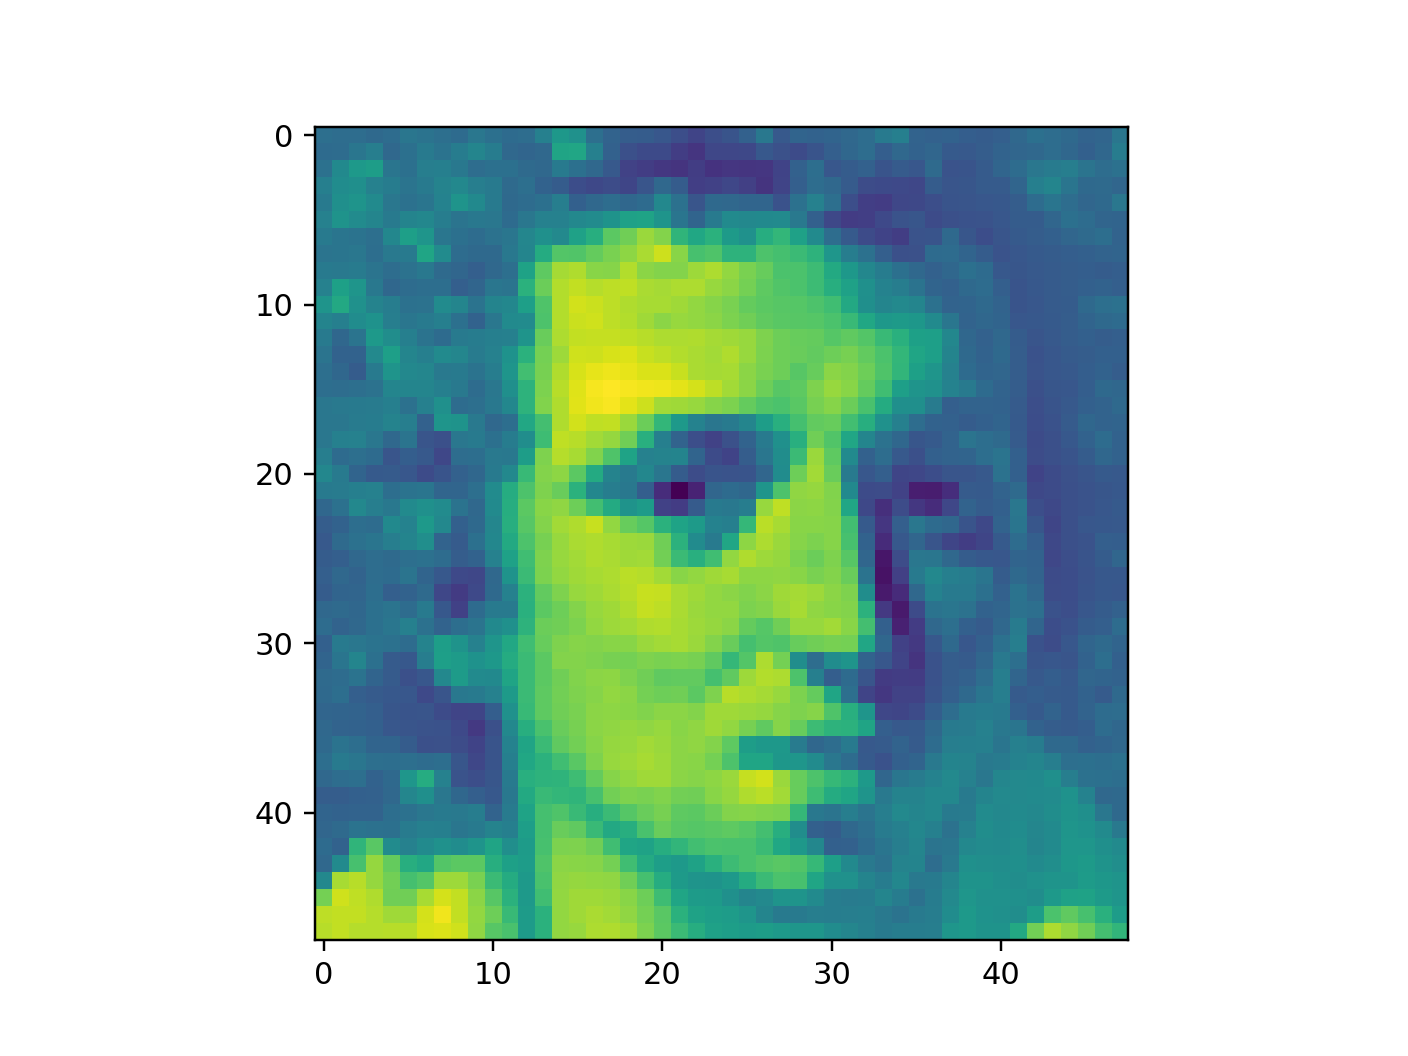

6


In [166]:
faces.shape
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
i = 1000
ax.imshow(faces[i])
print(mood[i])

In [20]:
mean = np.mean(faces,axis=0)
std = np.std(faces,axis=0)
faces = (faces-mean)/std

In [168]:
faces = faces.reshape(faces.shape[0],48,48)
N = len(faces)
print(N)
x_train = faces[:N//4*3]
y_train = mood

35887


In [24]:
import mygrad as mg
from mygrad import Tensor

In [75]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [158]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout
from mynn.activations.relu import relu
from mynn.initializers.glorot_normal import glorot_normal
from mygrad.nnet.layers import max_pool
from mynn.losses.cross_entropy import softmax_cross_entropy

In [160]:
class Model:
    ''' A simple convolutional neural network. '''
    init = glorot_normal
    def __init__(self,dim_in=48, num_out=7):
        self.conv1 = conv(1, 32, 2, 2, stride=1, padding=0, weight_initializer=Model.init)
        self.conv2 = conv(32, 64, 3, 3, stride=2, padding=1, weight_initializer=Model.init)
        self.conv3 = conv(64, 128, 2, 2, stride=2, weight_initializer=Model.init)
        self.conv4 = conv(128, 256, 3, 3, stride=3, weight_initializer=Model.init)
        self.dense1 = dense(256, 512, weight_initializer=Model.init)
        self.dense2 = dense(512, num_out, weight_initializer=Model.init)
    def __call__(self, x):
        x = relu(self.conv1(x))
        x = max_pool(relu(self.conv2(x)), (2,2), (2,2))
        x = relu(self.conv3(x))
        x = max_pool(relu(self.conv4(x)), (2,2), (2,2))
        x = x.reshape(x.shape[0], 256)
        x = relu(self.dense1(x))
        x = self.dense2(x)
        return x
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        # This function should return a tuple of all of the trainable parameters of
        # your model. Recall that MyNN nicely gives you access to each layer's parameters:
        # `layer.paramters` will return a tuple of the parameters for a given layer. 
        # E.g. `dense_layer.parameters` -> (w, b)
        
        # STUDENT CODE
        params = []
        for layer in (self.conv1,self.conv2,self.conv3,self.conv4,self.dense1,self.dense2):
            params += list(layer.parameters)
        return params

In [161]:
# STUDENT CODE
from mynn.optimizers.adam import Adam
model = Model()
optim = Adam(model.parameters)

In [162]:
import liveplot
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


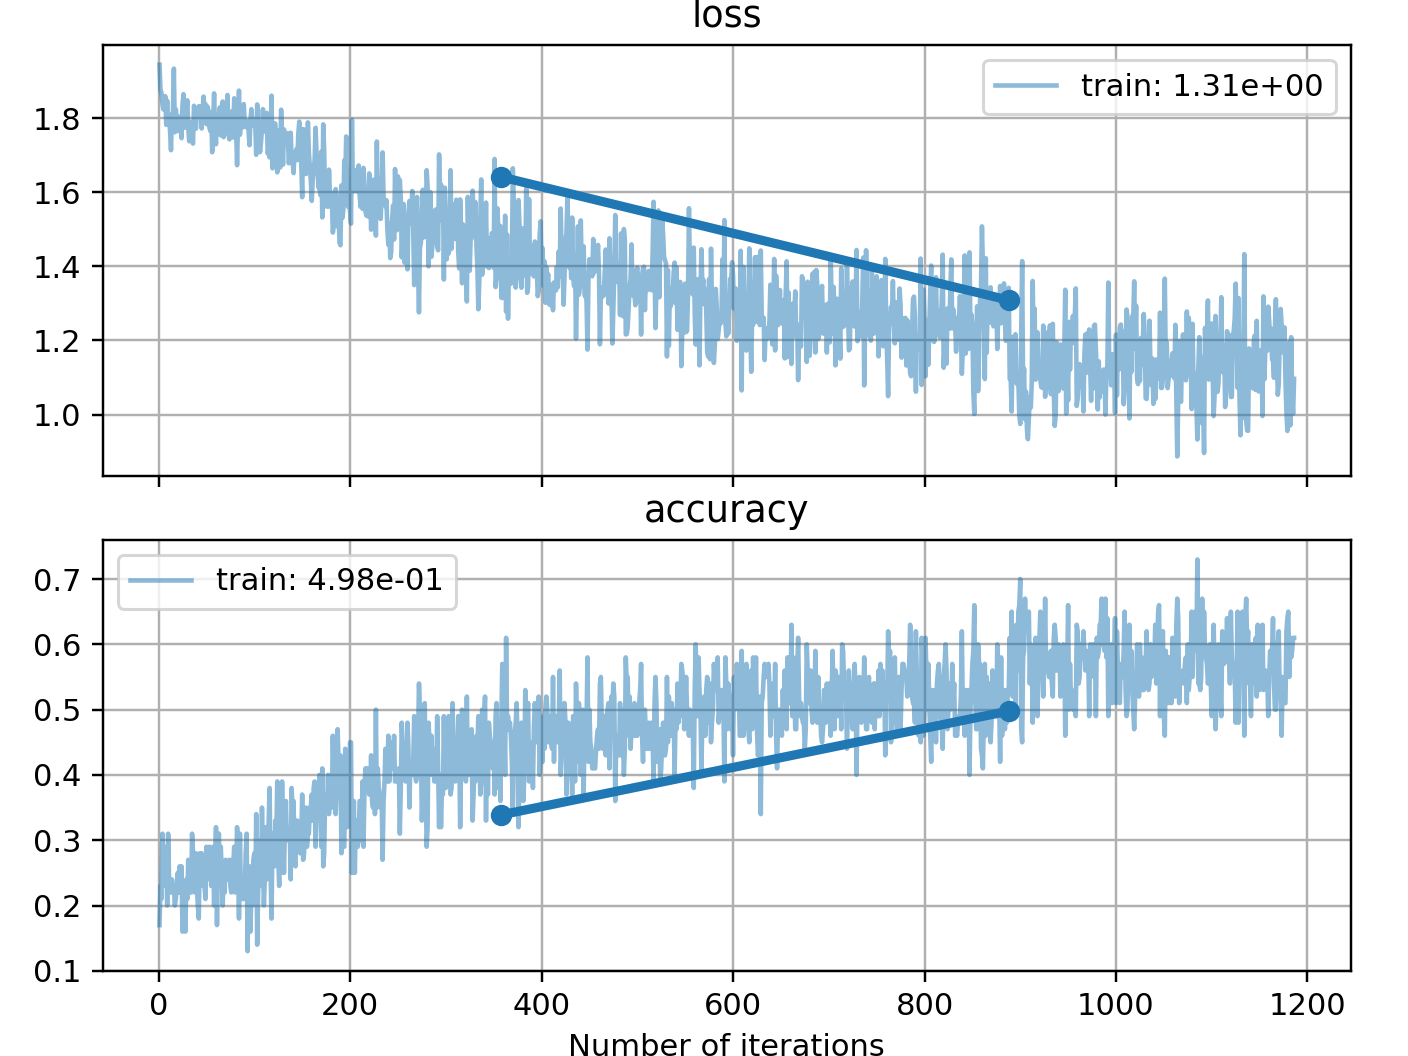

In [163]:
# STUDENT CODE
plotter, fig, ax = liveplot.create_plot(["loss","accuracy"], refresh=2.5)

In [167]:
batch_size = 100

# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(10):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
        
    for batch_cnt in range(len(x_train)//batch_size):#len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_train[batch_indices]  # random batch of our training data
        batch = batch.reshape((batch.shape[0],1,batch.shape[-2],batch.shape[-1]))
        # compute the predictions for this batch by calling on model
        prediction = model(batch)
        # compute the true (a.k.a desired) values for this batch: 
        truth = y_train[batch_indices]
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = softmax_cross_entropy(prediction, truth)

        # back-propagate through your computational graph through your loss
        loss.backward()

        # compute the accuracy between the prediction and the truth 
        acc = accuracy(prediction, truth)
        optim.step()

        loss.null_gradients()
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                batch_size=batch_size)
    
    # this tells liveplot to plot the epoch-level train/test statistics :)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()    

KeyboardInterrupt: 

## print (batch_indices)

In [ ]:
print (np.shape(x_train))